I've found an interesting contribution to fringe fraction variability

The "orignal" code (commit https://github.com/MSLNZ/ls-fringeapp/commit/d9f5aa35f5e03e1d8b9a2f1d18dd3e40f0dfe784 on master branch)  

converts the colour image to a numpy aarray as follows
original code in master branch `FringeManager.open_image` 

```python
        img = Image.open(self.img_filename)
        img.convert("L")
        self.img_array = np.asarray(img)
        if self.img_array.ndim > 2:
            self.img_array = self.img_array.mean(axis=2)
```

This code appears to use  the PIL library 
`img.convert("L")` to convert to grey scale but the image is not converted inplace. This line should be
`img = img.convert("L")`
The code then goes on to take the mean of the RGB channels in `self.img_array`

The PIL library uses by default a weighted matrix to convert to grey scale
>  L = R * 299/1000 + G * 587/1000 + B * 114/1000

https://pc-pillow.readthedocs.io/en/latest/Image_class/Image_convert.html#image-convert

using the default
```python
img = Image.open(self.img_filename)
img = img.convert("L")
self.img_array = np.asarray(img)
```

gives differnt fringe fractions than using

```python
img = Image.open(self.img_filename)
self.img_array = np.asarray(img)
if self.img_array.ndim > 2:
    self.img_array = self.img_array.mean(axis=2)
```
see below

In [8]:
from pathlib import Path
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from ls_fringeapp import fringeprocess as fp
from ls_fringeapp.load_equipment_data import repo_folder


In [9]:
TEST_DATA_DIR = repo_folder / "tests" / "data"
data = np.genfromtxt(
    TEST_DATA_DIR / "fflog_to_test_2025-11-11.txt", delimiter="\t", dtype="str"
)


In [10]:
def test_fringe_calc(row):
    img_filename = TEST_DATA_DIR / row[1]
    xygb = row[2:8].astype(float)
    xygb = xygb.reshape((3, 2))

    # original calculation
    img = Image.open(img_filename)
    img_array = np.asarray(img)
    if img_array.ndim > 2:
        img_array = img_array.mean(axis=2)
    ffrac_mean_gs = fp.array2frac(img_array, xygb)

    # default PIL conversion to greyscale
    img = Image.open(img_filename)
    img = img.convert("L")
    img_array = np.asarray(img)
    ffrac_pil_default = fp.array2frac(img_array, xygb)

    # unweighted PIL conversion to greyscale
    img = Image.open(img_filename)
    img = img.convert("L", matrix=(1 / 3, 1 / 3, 1 / 3, 0))
    img_array = np.asarray(img)
    ffrac_pil_unweighted = fp.array2frac(img_array, xygb)

    return ffrac_mean_gs, ffrac_pil_default, ffrac_pil_unweighted


In [11]:
ffracs = []
for row in data:
    ffs_img = test_fringe_calc(row)
    ffracs.append(ffs_img)
ffracs = np.array(ffracs)
ffracs


array([[0.30395152, 0.3075764 , 0.30272372],
       [0.51021629, 0.51088766, 0.51042499],
       [0.70396858, 0.70446349, 0.7038843 ],
       [0.11998809, 0.11764502, 0.11835323],
       [0.60655908, 0.60655318, 0.60726918],
       [0.90602474, 0.90592089, 0.90640312],
       [0.54531653, 0.54527008, 0.54527715],
       [0.86533675, 0.86532748, 0.86557179],
       [0.03941088, 0.04011329, 0.04003334]])

In [12]:
# remove row mean
ff_norm = ffracs - ffracs.mean(axis=1).reshape(-1, 1)
ff_norm

array([[-7.99027046e-04,  2.82585466e-03, -2.02682762e-03],
       [-2.93355722e-04,  3.78012936e-04, -8.46572141e-05],
       [-1.36878446e-04,  3.58037723e-04, -2.21159277e-04],
       [ 1.32597784e-03, -1.01709604e-03, -3.08881793e-04],
       [-2.34735121e-04, -2.40630115e-04,  4.75365236e-04],
       [-9.15109357e-05, -1.95358163e-04,  2.86869099e-04],
       [ 2.86091831e-05, -1.78363517e-05, -1.07728315e-05],
       [-7.52582585e-05, -8.45276220e-05,  1.59785880e-04],
       [-4.41626158e-04,  2.60790870e-04,  1.80835288e-04]])

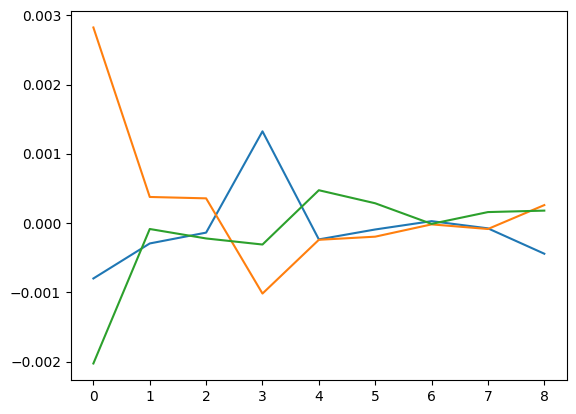

In [13]:
plt.plot(ff_norm)

In [17]:
max_diff = abs(ff_norm).max()
max_diff_nm = max_diff * 633 / 2
max_diff, max_diff_nm

(np.float64(0.002825854664417371), np.float64(0.8943830012880979))

In [18]:
mean_diff = ff_norm.mean()
mean_diff_nm = mean_diff * 633 / 2
mean_diff, mean_diff_nm

(np.float64(-9.508854609058054e-18), np.float64(-3.009552483766874e-15))

In [19]:
std_diff = ff_norm.std(ddof=1)
std_diff_nm = std_diff * 633 / 2
std_diff, std_diff_nm

(np.float64(0.0008051551031623056), np.float64(0.25483159015086976))


Note  
`img = img.convert("L", matrix= (1/3, 1/3, 1/3, 0))`  
`img_array = np.asaaray(img)`  
is not equivalent to   
`img_array = np.asaaray(img)`  
`img_array = img_array.mean(axis=2)`  

The 1st image has much more variation between the methods.


In [5]:
# look in more detail at 1st row
row = data[0]
img_filename = TEST_DATA_DIR / row[1]
print(img_filename)


def three_greyscale(img_filename):
    # original calculation
    img = Image.open(img_filename)
    img_array0 = np.asarray(img)
    if img_array0.ndim > 2:
        img_array0 = img_array0.mean(axis=2)

    # default PIL conversion to greyscale
    img = Image.open(img_filename)
    img = img.convert("L")
    img_array1 = np.asarray(img)

    # unweighted PIL conversion to greyscale
    img = Image.open(img_filename)
    img = img.convert("L", matrix=(1 / 3, 1 / 3, 1 / 3, 0))
    img_array2 = np.asarray(img)
    return img_array0, img_array1, img_array2


img_array0, img_array1, img_array2 = three_greyscale(img_filename)

/home/elfnor/gits/ls-fringeapp/tests/data/MSL-01_01-G.jpg


In [7]:
type(img_array0), type(img_array0[0, 0])

(numpy.ndarray, numpy.float64)

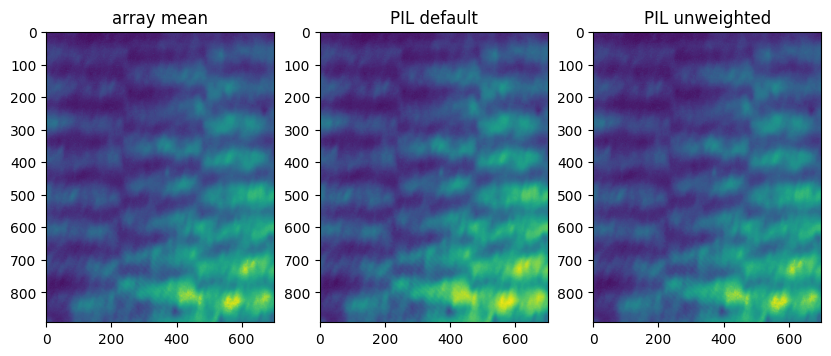

In [58]:
# plot 3 arrays for 1st image
plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(img_array0)
plt.axis("image")
plt.title("array mean")

plt.subplot(132)
plt.imshow(img_array1)
plt.axis("image")
plt.title("PIL default")

plt.subplot(133)
plt.imshow(img_array2)
plt.axis("image")
plt.title("PIL unweighted");

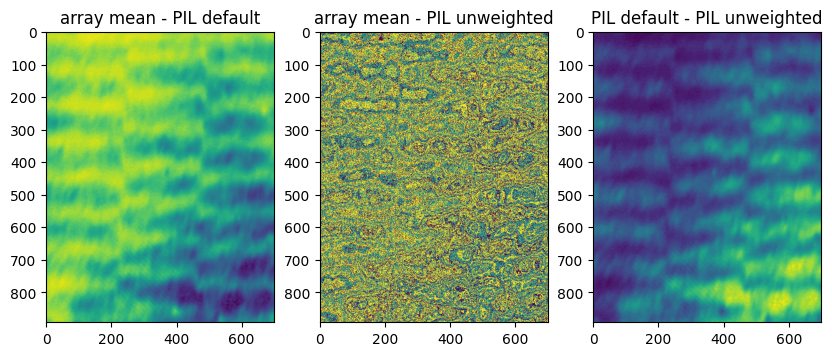

In [59]:
# difference bewtween pairs
img_array_d01 = img_array0 - img_array1
img_array_d02 = img_array0 - img_array2
img_array_d12 = img_array1 - img_array2

plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(img_array_d01)
plt.axis("image")
plt.title("array mean - PIL default")

plt.subplot(132)
plt.imshow(img_array_d02)
plt.axis("image")
plt.title("array mean - PIL unweighted")

plt.subplot(133)
plt.imshow(img_array_d12)
plt.axis("image")
plt.title("PIL default - PIL unweighted");

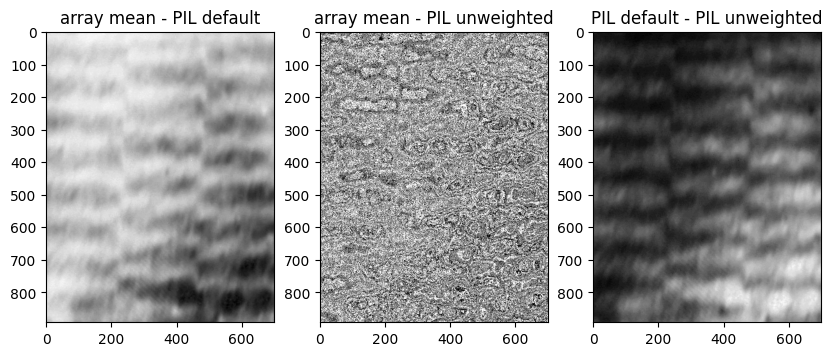

In [ ]:
# difference bewtween pairs
img_array_d01 = img_array0 - img_array1
img_array_d02 = img_array0 - img_array2
img_array_d12 = img_array1 - img_array2

plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(img_array_d01, cmap=matplotlib.cm.gray)
plt.axis("image")
plt.title(
    "array mean - PIL default",
)

plt.subplot(132)
plt.imshow(img_array_d02, cmap=matplotlib.cm.gray)
plt.axis("image")
plt.title("array mean - PIL unweighted")

plt.subplot(133)
plt.imshow(img_array_d12, cmap=matplotlib.cm.gray)
plt.axis("image")
plt.title("PIL default - PIL unweighted");

PIL must do some dithering or some such in grey scale conversion, given the non-uniform color of the middle image

>dither - Dithering method, used when converting from mode “RGB” to “P” or from “RGB” or “L” to “1”. Available methods are Dither.NONE or Dither.FLOYDSTEINBERG (default). Note that this is not used when matrix is supplied.

I'm surprised that PIl default - PIL unweighted is not uniform?

In [61]:
img = Image.open(img_filename)
img = img.convert("L", matrix=(1 / 3, 1 / 3, 1 / 3, 0), dither=None)
img_array4 = np.asarray(img)

(np.float64(-0.5), np.float64(699.5), np.float64(891.5), np.float64(-0.5))

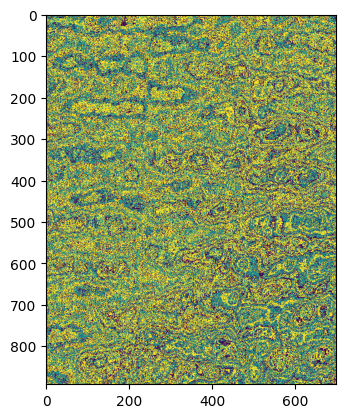

In [62]:
img_array_d04 = img_array0 - img_array4
plt.imshow(img_array_d04)
plt.axis("image")


(np.float64(-0.5), np.float64(659.5), np.float64(322.5), np.float64(-0.5))

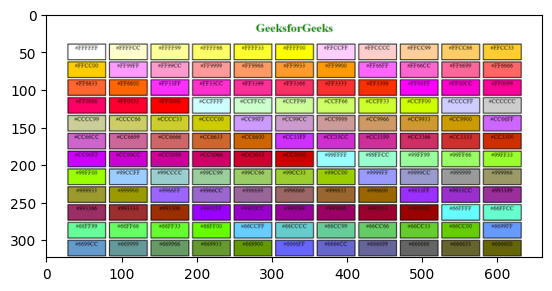

In [63]:
# look at a palette of colors
img_filename = TEST_DATA_DIR / "Screenshot41911-660x323.png"

img = Image.open(img_filename)
plt.imshow(np.asarray(img))
plt.axis("image")


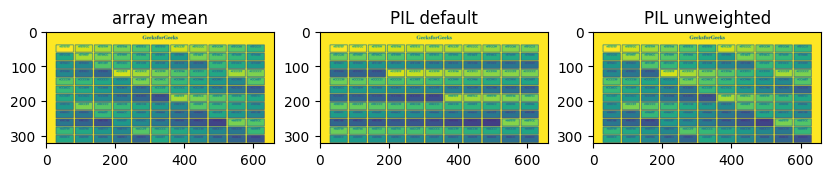

In [ ]:
img_array0, img_array1, img_array2 = three_greyscale(img_filename)

plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(img_array0)
plt.axis("image")
plt.title("array mean")

plt.subplot(132)
plt.imshow(img_array1)
plt.axis("image")
plt.title("PIL default")

plt.subplot(133)
plt.imshow(img_array2)
plt.axis("image")
plt.title("PIL unweighted");

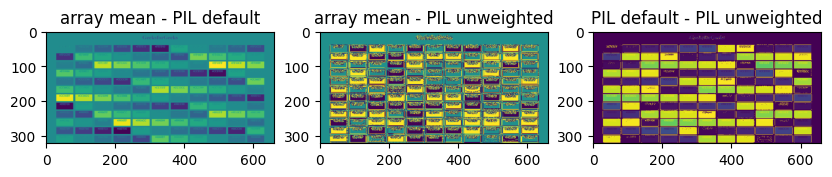

In [65]:
# difference bewtween pairs
img_array_d01 = img_array0 - img_array1
img_array_d02 = img_array0 - img_array2
img_array_d12 = img_array1 - img_array2

plt.figure(figsize=(10, 6))

plt.subplot(131)
plt.imshow(img_array_d01)
plt.axis("image")
plt.title("array mean - PIL default")

plt.subplot(132)
plt.imshow(img_array_d02)
plt.axis("image")
plt.title("array mean - PIL unweighted")

plt.subplot(133)
plt.imshow(img_array_d12)
plt.axis("image")
plt.title("PIL default - PIL unweighted");

Text(0.5, 1.0, 'array mean - PIL unweighted')

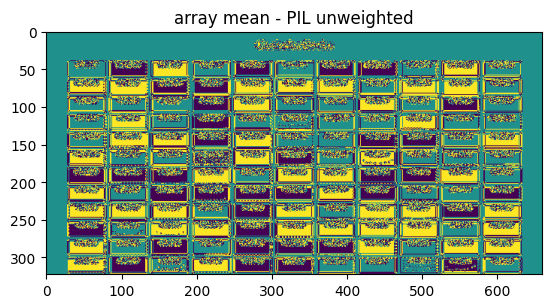

In [66]:
plt.imshow(img_array_d02)
plt.axis("image")
plt.title("array mean - PIL unweighted")

weird I think I just stick with the array mean